### Librerias Necesarias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     GridSearchCV
                                    )
from sklearn.metrics import (mean_squared_log_error, 
                             mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             accuracy_score,
                             recall_score,
                             f1_score, precision_score,
                             plot_confusion_matrix,
                             roc_curve, auc,confusion_matrix
                            )

from sklearn.cluster import KMeans
from sklearn.ensemble import (IsolationForest,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              StackingClassifier
                             )
from sklearn.linear_model import (LinearRegression,
                                  Ridge,
                                  Lasso,
                                  LogisticRegression
                                 )

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import (SelectKBest,
                                       chi2,
                                       mutual_info_classif
                                      )

from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   label_binarize
                                  )
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier

# Deep Learning
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (Dense, 
                          Activation,
                          Dropout,
                         )

from keras.optimizers import (Adam, 
                              SGD, 
                              RMSprop)

from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical

# configuracion diagrama de outliers
flp = dict(marker="o",
           markerfacecolor="red",
           markersize=5,
           linestyle="--",
           markeredgecolor="black")

# Prueba para científico de datos

## Parte 1 - Cargar datos y estadísticas básicas

En la carpeta ```Data``` encontrará un archivo llamado ```diamonds.csv```. Este archivo contiene información de 53940 diamantes. Dentro de la información disponible, está el precio, el color, el peso, etc. Puede consultar las características completas del dataset en [este enlace](https://www.kaggle.com/shivam2503/diamonds).

1. Cargue el archivo en un dataframe de pandas 
2. Use los metodos que conozca para describir las propiedades básicas de los datos. 

### 1. Lectura de datos

In [2]:
data = pd.read_csv("Data/diamonds.csv",  delimiter=",", index_col=0)
data

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


En primer lugar se debe verificar si la matriz de datos tiene datos faltantes

In [3]:
print(data.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


Se debe notar que los valores que tengan cero o menor en las dimensiones son datos erroneos y no proveen información conrrecta al modelo que se construya, por lo tanto se borran estos valores de la base de datos 

In [3]:
data = data.drop(data.loc[(data["x"] == 0) & (data["x"] < 0)].index)
data = data.drop(data.loc[(data["y"] == 0) & (data["y"] < 0)].index)
data = data.drop(data.loc[(data["z"] == 0) & (data["z"] < 0)].index)

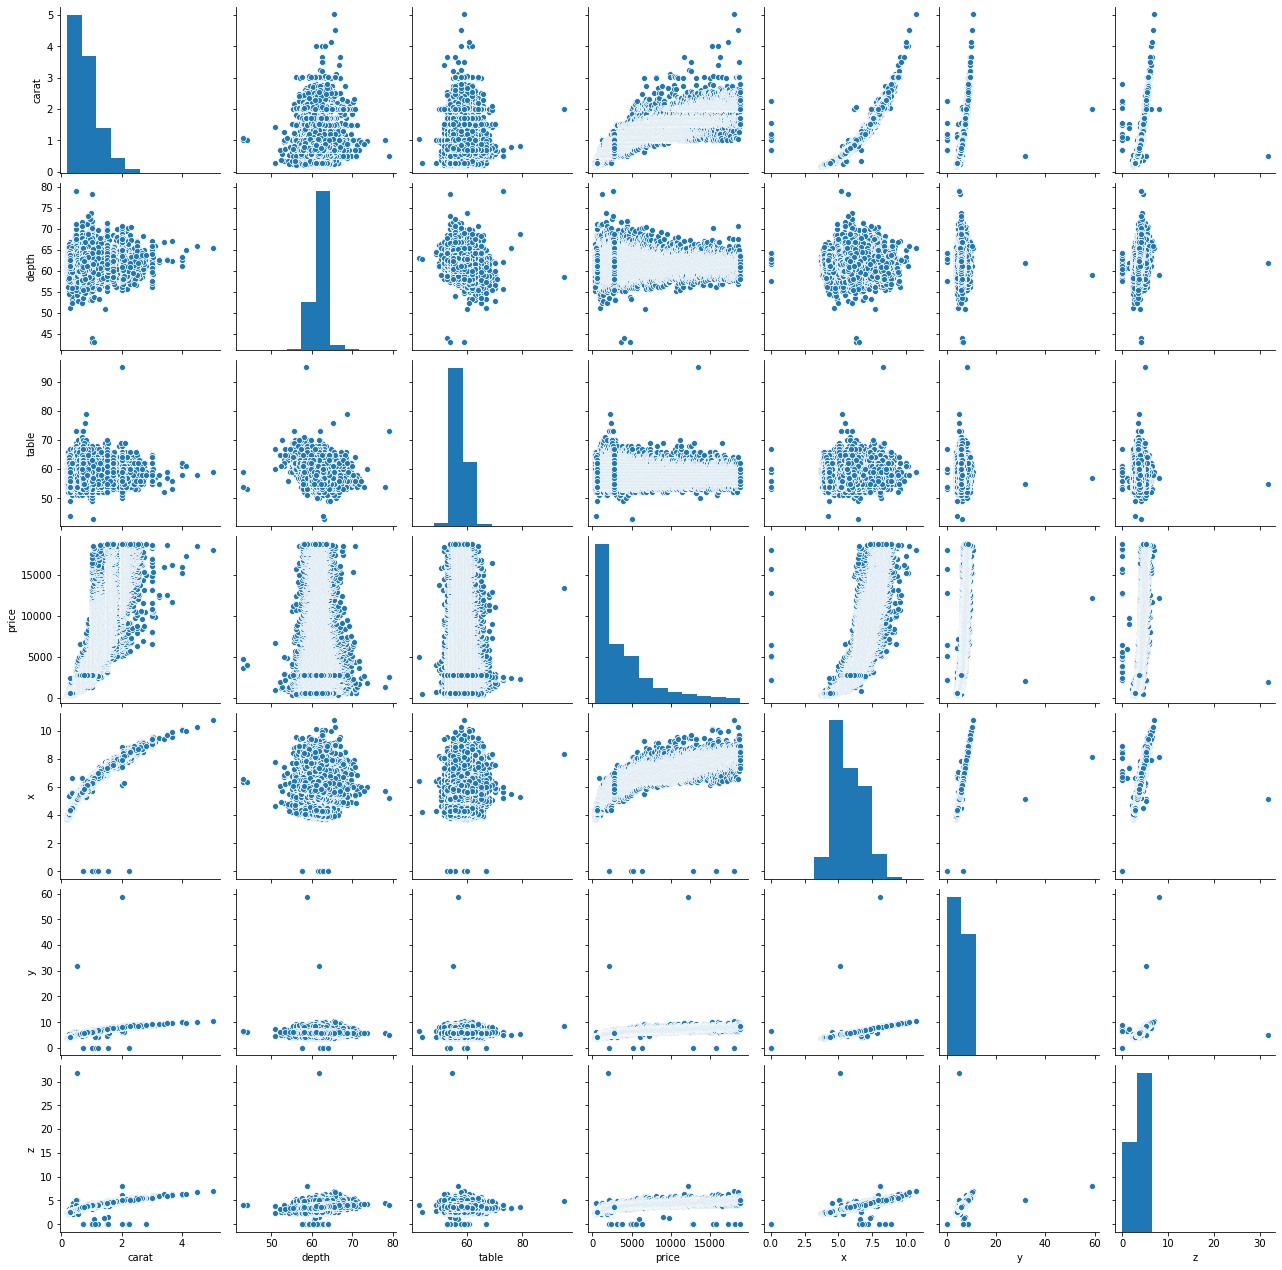

In [5]:
sns.pairplot(data[data.select_dtypes(include=["float64", "int64"]).columns])


Luego de esto hace un análisis de las variables dependiendo la tipología. Se empieza una revisión de las variables categóricas

# Variables Categóricas

## Cut 
Calidad del corte puede tomar 5 valores (Fair, Good, Very Good, Premium, Ideal), se muestra la distribución de la variable para ver su distribución. Adicional a esto se hace una codificación  para que los algoritmos puedan entender las variables categóricas 


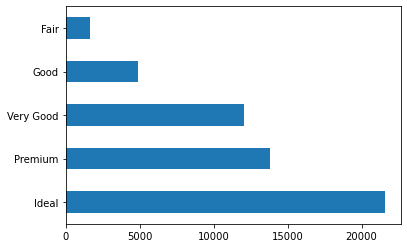

In [4]:
# Se usa un diccionario para relacionar la nueva codificacion
data["cut"].value_counts().plot.barh()
X = pd.get_dummies(data["cut"])


## Color

Calsificación del color por categorías, en donde se tiene una escala J(Peor) y  D(mejor). Se hace codificación para los tipos de colores con número del 1 al 7 



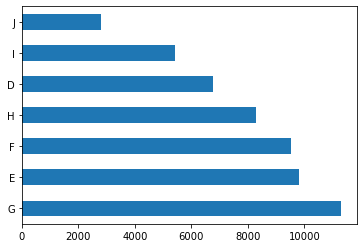

In [5]:
data["color"].value_counts().plot.barh()
X = pd.concat([X, pd.get_dummies(data["color"])], axis=1)

## Claridad 

medidad de claridad del diamante en donde la escala se entiende como I1(peor), SI2, SI1, VS2, VS1, VVS2, VVS1, IF(mejor). Se codifica la variable 

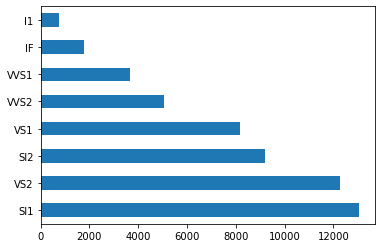

In [6]:
data["clarity"].value_counts().plot.barh()
X = pd.concat([X, pd.get_dummies(data["clarity"])], axis=1)

# variables Continuas 

## carat

Peso en quilates del diamante, definición ($1 ct = 0,2g$). En principio no se ve una distribución evidente, se lista la estadística descriptiva de la variable

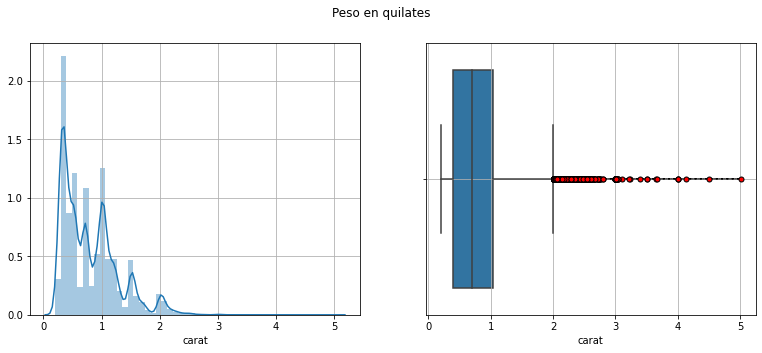

In [7]:
fig, ax =plt.subplots(1,2,figsize=(13,5))
fig.suptitle("Peso en quilates")
sns.distplot(data["carat"], ax=ax[0])
ax[0].grid(True)
sns.boxplot(x=pd.to_numeric(data["carat"]),flierprops=flp, ax = ax[1])
ax[1].grid(True)
data["carat"].describe()

X = pd.concat([X, data["carat"]], axis=1)


## depth 

porcentaje de profundidad total, que se calcula como 


$$T = \frac{2z}{x+y}$$

Puede ser una variable sintética de los datos

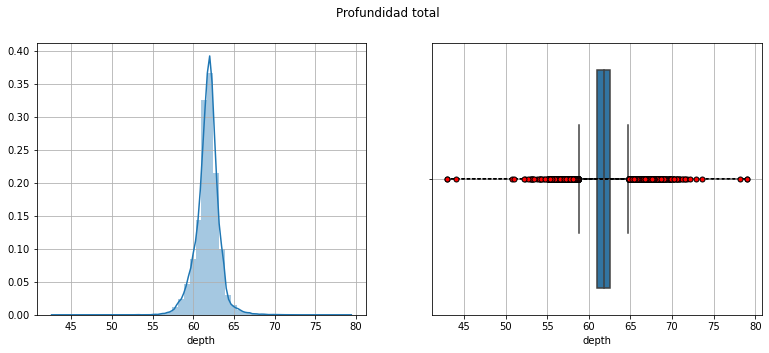

In [8]:
fig, ax =plt.subplots(1,2,figsize=(13,5))
fig.suptitle("Profundidad total")
sns.distplot(data["depth"], ax=ax[0])
ax[0].grid(True)
sns.boxplot(x=pd.to_numeric(data["depth"]),flierprops=flp, ax = ax[1])
ax[1].grid(True)
data["depth"].describe()

X = pd.concat([X, data["depth"]], axis=1)


## table

ancho de la parte superior del diamante en relación con el punto más ancho. Se puede evidenciar una distribución normal, salvo de valores atípicos que también se muestran.

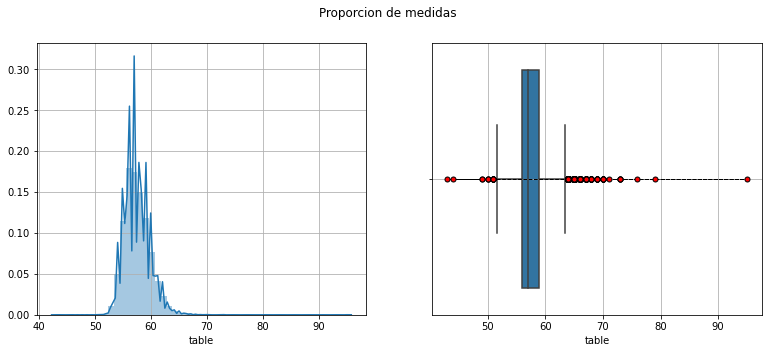

In [9]:
fig, ax =plt.subplots(1,2,figsize=(13,5))
fig.suptitle("Proporcion de medidas")
sns.distplot(data["table"], ax=ax[0])
ax[0].grid(True)
sns.boxplot(x=pd.to_numeric(data["table"]),flierprops=flp, ax = ax[1])
ax[1].grid(True)
data["table"].describe()

X = pd.concat([X, data["table"]], axis=1)


## Dimensiones

x,y,z Longitud en milimetros del diamante

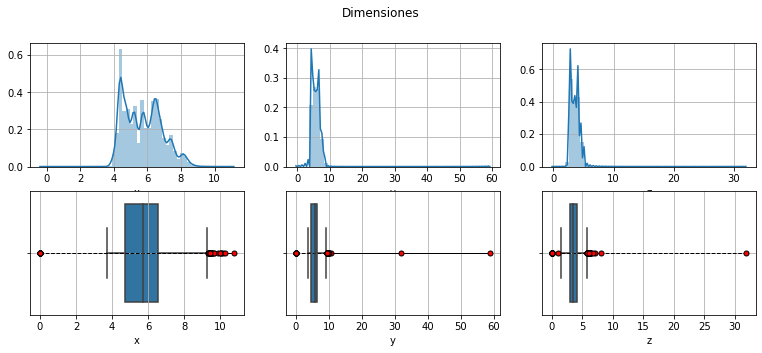

In [10]:
fig, ax =plt.subplots(2,3,figsize=(13,5))
fig.suptitle("Dimensiones")
sns.distplot(data["x"], ax=ax[0,0])
ax[0, 0].grid(True)
sns.distplot(data["y"], ax=ax[0,1])
ax[0, 1].grid(True)
sns.distplot(data["z"], ax=ax[0,2])
ax[0, 2].grid(True)
sns.boxplot(x=pd.to_numeric(data["x"]), flierprops=flp, ax=ax[1,0])
ax[1, 0].grid(True)
sns.boxplot(x=pd.to_numeric(data["y"]), flierprops=flp, ax=ax[1,1])
ax[1, 1].grid(True)
sns.boxplot(x=pd.to_numeric(data["z"]), flierprops=flp, ax=ax[1,2])
ax[1, 2].grid(True)



Se eliminan los outliers en el tamaño en cada dimensión 

In [11]:
# data = data.drop(data.loc[data.x < 2].index)
# data = data.drop(data.loc[data.y > 30].index)
# data = data.drop(data.loc[data.z > 25].index)
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)     ############### ESTE ES EL ALGORITMO DE ELIMINACIÓN DE OUTLIERS ####################
outliers_dimension = iso.fit_predict(data[["x", "y", "z"]]) 

# # select all rows that are not outliers
outliers_dimension = outliers_dimension != -1
data = data[outliers_dimension] #Se elmininan todos los outliers de gasto_familiar


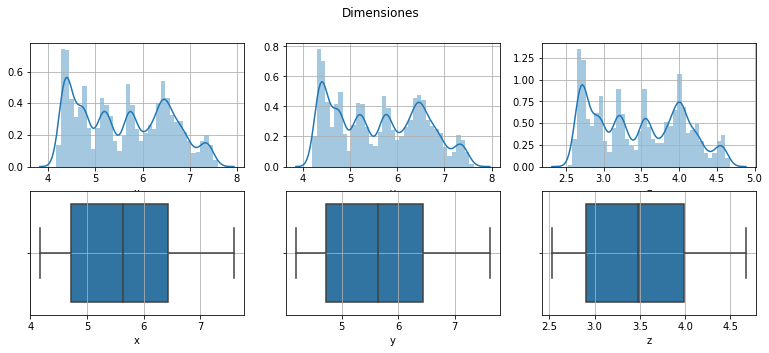

In [12]:
fig, ax =plt.subplots(2,3,figsize=(13,5))
fig.suptitle("Dimensiones")
sns.distplot(data["x"], ax=ax[0,0])
ax[0, 0].grid(True)
sns.distplot(data["y"], ax=ax[0,1])
ax[0, 1].grid(True)
sns.distplot(data["z"], ax=ax[0,2])
ax[0, 2].grid(True)
sns.boxplot(x=pd.to_numeric(data["x"]), flierprops=flp, ax=ax[1,0])
ax[1, 0].grid(True)
sns.boxplot(x=pd.to_numeric(data["y"]), flierprops=flp, ax=ax[1,1])
ax[1, 1].grid(True)
sns.boxplot(x=pd.to_numeric(data["z"]), flierprops=flp, ax=ax[1,2])
ax[1, 2].grid(True)

X = pd.concat([X, data["x"]], axis=1)
X = pd.concat([X, data["y"]], axis=1)
X = pd.concat([X, data["z"]], axis=1)


Podemos ver que estas variables pueden tener correlaciones especiales, dado que un diamante entre más grande sea más valor tiene en el mercado, veamos la matriz de correlacion de las dimensiones y el precio 

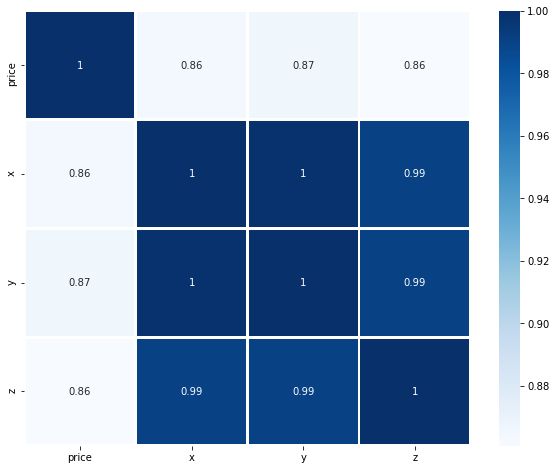

In [13]:
correlation = data[["price", "x", "y", "z"]].corr()

f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(correlation, cmap="Blues", annot=True, linewidths=2)

Se puede ver como se ubica el volumen en un grafico tridimensional que indique el agrupamiento de volumenes

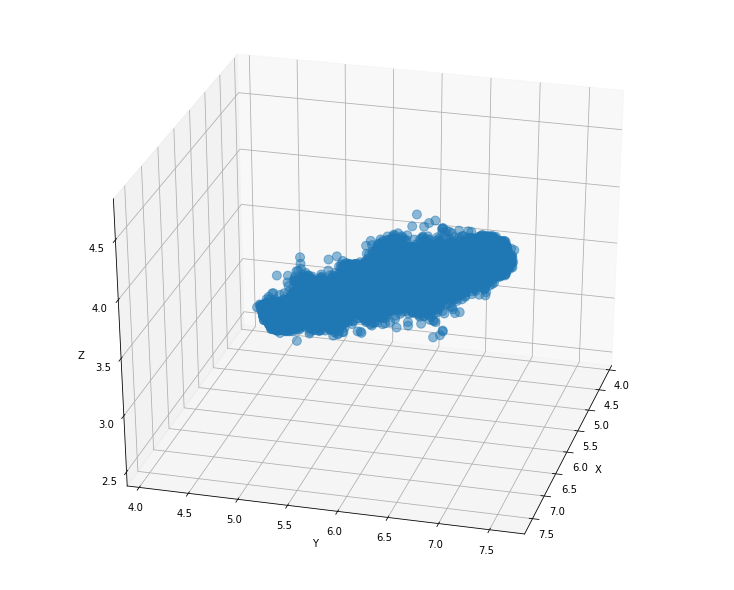

In [16]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(xs=data["x"], ys=data["y"], zs=data["z"], s=80, alpha=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=30, azim=15)

Se crea una variable adicional que reemplaze x,y,z. definiendo el volumen asi 

In [14]:
data["Volumen"] = data["x"]*data["y"]*data["z"]
X = pd.concat([X, data["Volumen"]], axis=1)
X = X.drop(["x", "y", "z"], axis=1)


Entonces se puede ver la relación entre el volumen y el precio, ademas de otras características 

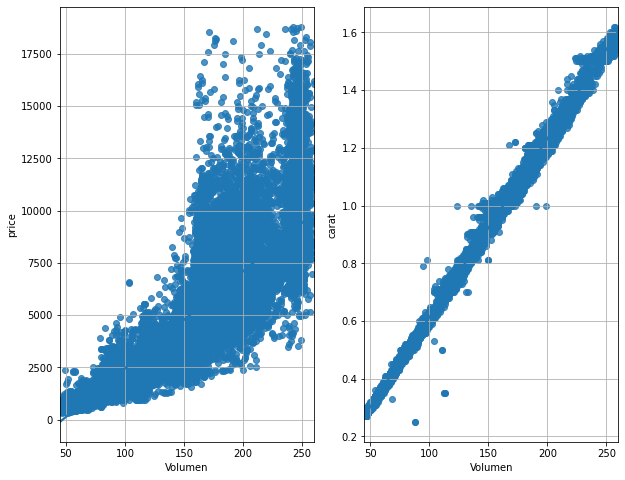

In [18]:
f, axes = plt.subplots(1,2, figsize=(10,8), sharex=False)
sns.regplot(x="Volumen", y="price", data=data, ax=axes[0], fit_reg=True)
sns.regplot(x="Volumen", y="carat", data=data, ax=axes[1], fit_reg=True)
axes[0].grid(True)
axes[1].grid(True)

# Variable objetivo

## Precio

Precio en dolares 


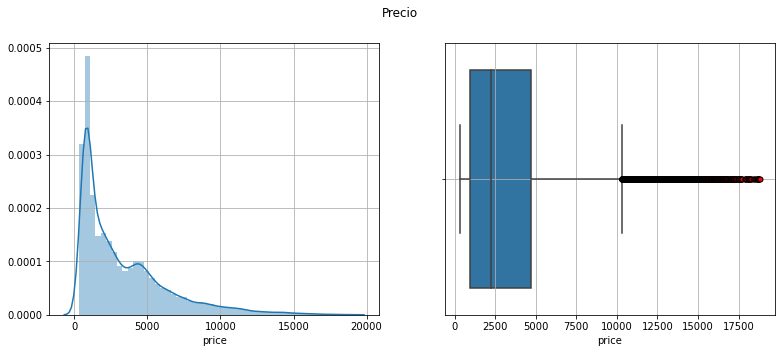

In [15]:
fig, ax =plt.subplots(1,2,figsize=(13,5))
fig.suptitle("Precio")
sns.distplot(data["price"], ax=ax[0])
ax[0].grid(True)
sns.boxplot(x=pd.to_numeric(data["price"]),flierprops=flp, ax = ax[1])
ax[1].grid(True)
data["price"].describe()

X = pd.concat([X, data["price"]], axis=1)


In [16]:
X.dropna(inplace=True)

## Parte 2 - Aprendizaje no supervisado

Usted desea encontrar estructura en los datos que le han sido dados. 
1. A partir del dataframe que cargó en el primer punto, use algún algoritmo de aprendizaje no supervisado para encontrar clusters de diamantes con propiedades similares. 
2. En una celda de markdown, describa una métrica/método que se pueda utilizar para evaluar la calidad de sus clusters.
3. Varie $k$ (la cantidad de clusters) de 1 a 10 y grafique su métrica en función de $k$
4. Qué $k$ describe mejor sus datos? 

___

Se usará K-means, un algoritmo de clustering no supervisado muy famoso, de los más simples. Este algoritmo busca minimizar una función obejtivo

$$J = \sum_{j=1}^{k}\sum_{i=1}^{n}\omega_{ij}|x_{i}^{(j)}-c_{j}|^{2}$$

donde se elige una distancia entre el dato $x_{i}$ y el cluster $c_{j}$, $\omega_{ij}$ es una función a trozos que determina la pertencia del punto a un determinado cluster. Es un indicador de la distancia de los puntos n en referencia al j-ésimo cluster.

En principio no se tiene clara la métrica para evaluar el rendimiento, dado que se requiere un $k$ de entrada y no lo aprende de los datos, no se tiene una teoría clara acerca de la cantidad de clusters para un determinado conjunto de datos. Lo que se pretende hacer es probar varios $k$ usando el método de codo. Este procedimiento da una buena idea de cual será una cantidad apropiada para $k$, usando alguna función de distancia que en este caso sera la suma de distancias al cuadrado entre los puntos de datos y los centroides de los clusters, se hace de esta manera porque k-means se basa implicitamente en distancias euclidianas por pares entre puntos de datos, es una medida multivariante es por esta razón que se elige esta métrica para minimizar esta distancia. se elige el $k$ que produzca el punto de inflexión en la curva de error en función de $k$. 

No se incluyen las variables categóricas dado que la naturaleza del algoritmo es minimizar la distancia en el espacio de variables, asumir que la codificación le da atribuciones de distancia a las variables categóricas es un error por tanto se agrupan los diamantes en relación a sus medidas 


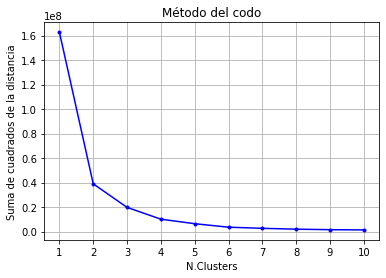

In [17]:
X_clust = np.array(X[["Volumen", "carat", "table"]])
k_fin = 10
x_data = np.arange(1, k_fin+1)
sse = []
for i in range(1, k_fin+1):
    #      
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 5, random_state = 0)
    km.fit(X_clust)
    sse.append(km.inertia_)


plt.plot(x_data, sse, "b.")
plt.plot(x_data, sse, "b-")
plt.title('Método del codo')
plt.xlabel('N.Clusters')
plt.xticks(x_data, x_data)
plt.ylabel('Suma de cuadrados de la distancia')
plt.grid(True)

Esta elección es un poco arbitraria, se elige $k=7$

In [22]:
k = 7
km = KMeans(n_clusters = k, random_state = 0)
y_means = km.fit_predict(X_clust)
centroids = km.cluster_centers_
print(centroids)

[[242.35796061   1.49942502  57.96437451]
 [ 87.15045175   0.53130924  57.06396963]
 [167.34065947   1.0305865   57.91484244]
 [ 57.17802534   0.34775461  56.89778873]
 [117.19515337   0.71858271  57.60627374]
 [197.62185924   1.21203843  57.50748675]
 [144.18112044   0.89606077  58.16936464]]


Text(0.5, 0, 'Forma')

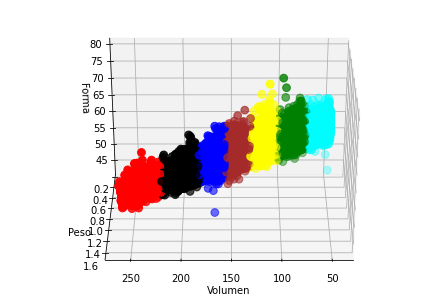

In [23]:
labels = km.predict(X_clust)

# Generacion de colores aleatorios dado un numero de cluster 
# dado


colors = ["red", 
          "green", 
          "blue", 
          "cyan", 
          "yellow",
          "black",
          "brown",
          "darkorange",
          "olive",
          "magenta"
         ]

colors = colors[:k]
asignar = []

for row in labels:
    asignar.append(colors[row])
    

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_clust[:, 0], X_clust[:, 1], X_clust[:, 2], c=asignar, s=60)
ax.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2], c="magenta" ,marker="o", s=60)
ax.view_init(elev=30, azim=90)
ax.set_xlabel("Volumen")
ax.set_ylabel("Peso")
ax.set_zlabel("Forma")


Se produjeron 7 clusters con los datos de los diamantes, agrupados por sus características físicas teniendo en cuenta el volumen, el peso en quilates y la relación entre su superficie y forma. Veamos graficas bidimensionales para clarificar las relaciones

### Relación entre el volumen y el peso

Text(0, 0.5, 'Peso')

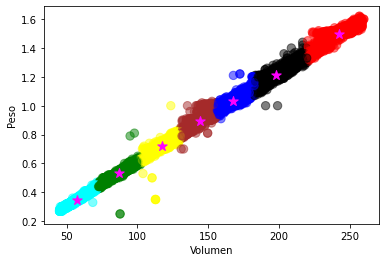

In [24]:
f1 = data['Volumen'].values
f2 = data['carat'].values
 
plt.scatter(f1, f2, c=asignar, s=70, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c="magenta", s=100)
plt.xlabel("Volumen")
plt.ylabel("Peso")

Es casi evidente la relación entre más voluminoso el diamante es más pesado, veamos cuantos diamantes existen en cada grupo teniendo en cuenta el volumen, el peso y la forma

In [25]:
copy = pd.DataFrame()
copy["label"] = labels
X_VP = pd.DataFrame()
X_VP["color"] = colors
X_VP["cantidad"] = copy.groupby("label").size()
X_VP

,color,cantidad
0,red,2571
1,green,7641
2,blue,7766
3,cyan,15829
4,yellow,6598
5,black,4518
6,brown,3623


### Relación entre volumen y la forma 

Text(0, 0.5, 'proporcion de Forma')

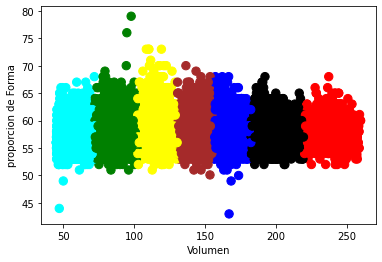

In [26]:
f1 = data['Volumen'].values
f2 = data['table'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c=colors, s=100)
plt.xlabel("Volumen")
plt.ylabel("proporcion de Forma")

### Relación entre la forma y el peso

Text(0, 0.5, 'proporcion de Forma')

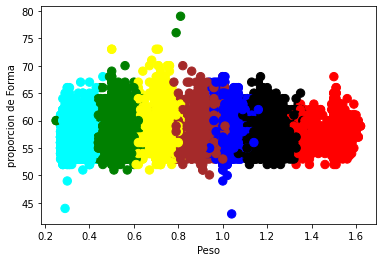

In [27]:
f1 = data['carat'].values
f2 = data['table'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c=colors, s=100)
plt.xlabel("Peso")
plt.ylabel("proporcion de Forma")

## Parte 3 - Reducción de dimensionalidad y regresión

Usted quiere predecir el precio del diamante a partir de sus características (toda columna en el dataset que no sea el precio). Sin embargo, tiene la intuición que varias columnas son redundantes - es decir - hay columnas que no aportan información nueva. 

1. Realice una reducción de dimensionalidad de los datos para evitar tener información redundante. Procure que en este nuevo espacio se explique por lo menos el 90% de la varianza de los datos.
2. En una celda de markdown, describa una métrica que se pueda utilizar para evaluar la calidad de su regresión y su habilidad para explicar los datos. 
3. Parta los datos en un conjunto de entrenamiento y otro de evaluación. 
3. Sobre este nuevo espacio, entrene un algoritmo de regresión para predecir el precio de los diamantes sobre el conjunto de entrenamiento. Evalue su algoritmo con su métrica sobre el conjunto de test. ¿Qué tan bien le va a su algoritmo? ¿Lo llevaría a producción? ¿Por qué? 


---

La selleción de parámetros en un paso importante para optimizar cualquier tarea Apredizaje automatizado. Veamos la matriz de correlación


In [30]:
y = X["price"]
x = X.drop(["price"], axis=1)

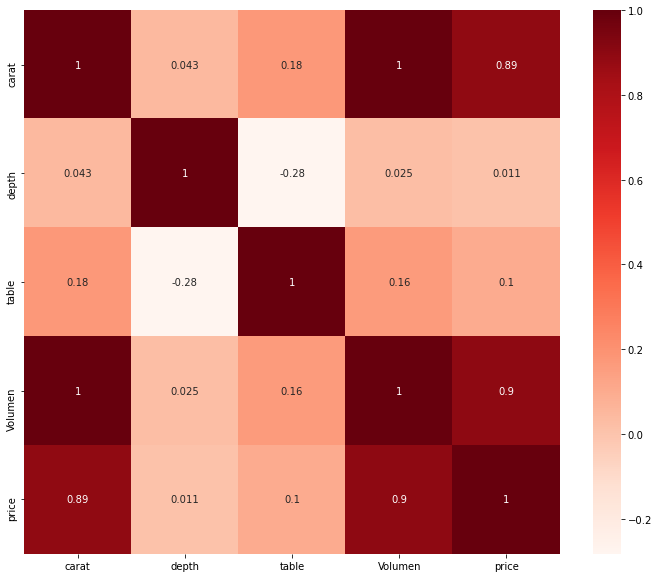

In [88]:
plt.figure(figsize=(12,10))
cor = X.select_dtypes(include=['float64','int64']).corr()
sns.heatmap(cor, annot=True ,cmap=plt.cm.Reds)

Como punto de referencia se pone una correlación de las variables explicativas de $r=0.5$ para saber que características tienen mayor aporte sobre la variable objetivo. 

In [64]:
cor_t = abs(cor["price"])
choose = cor_t[cor_t > 0.5]
choose

carat      0.893051
Volumen    0.895191
price      1.000000
Name: price, dtype: float64

Entonces todas las características diferentes a estas se va a despreciar, sin embargo debe respetarse la suposición de la regresión linean. Las variables independientes no deben estar fuertemente correlacionadas, veamos como es el caso

In [42]:
X[["carat", "Volumen"]].corr()

,carat,Volumen
carat,1.000000,0.998995
Volumen,0.998995,1.000000


El peso y Volumen se correlacionan fuertemente entonces se mantendra solamente una de estas variables que será al momento de entrenar el modelo. 



In [31]:
x = X.drop(["table", "depth","carat"], axis=1)


Por otro lado vamos a revisar la repercusión que tienen las variables categóricas en la variable objetivo. Se utiliza la selección de parámetros basada en la prueba de hipótesis de la estadística de $\chi^{2}$, da una prueba de independencia entre variables categóricas


<BarContainer object of 20 artists>

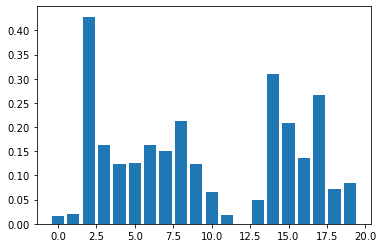

In [77]:
x_cat = x.drop(["Volumen"], axis=1)
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(x_cat,y)
# veamos la importancia de cada características
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)


In [78]:
for i in range(len(fs.scores_)):
    print("Variable {}  : {}".format(x_cat.columns[i], fs.scores_[i]))

a = np.percentile(fs.scores_, 20)

Variable Fair  : 0.015579541679738185
Variable Good  : 0.01977546302401656
Variable Ideal  : 0.42839796007334385
Variable Premium  : 0.1639316053890294
Variable Very Good  : 0.12389612056124832
Variable D  : 0.12647651278024874
Variable E  : 0.16230098747244348
Variable F  : 0.14974384964793153
Variable G  : 0.2131447210713091
Variable H  : 0.12281793850913836
Variable I  : 0.06606535174239347
Variable J  : 0.01912140851364441
Variable I1  : 0.0
Variable IF  : 0.048372607793780276
Variable SI1  : 0.30922926277945706
Variable SI2  : 0.20761195761918394
Variable VS1  : 0.13659062158915347
Variable VS2  : 0.26698304211456403
Variable VVS1  : 0.0717778431728906
Variable VVS2  : 0.08365243699807401


Dado esto se descartan los valores por debajo de 0,05. Esto tomando como referencia el percentil 20 de los datos  

In [32]:
x = x.drop(["Fair", "Good", "J", "I1", "IF"],axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Para la regresión se implementa un metamodelo que permite obtener las mejores características de cada regresión

In [34]:
# definicion de los modelos base
level0 = list()
# level0.append(("knn", KNeighborsRegressor(algorithm="brute", 
#                                           n_neighbors=3, 
#                                           weights="uniform")))
# level0.append(("dt", DecisionTreeRegressor(criterion="mae", 
#                                            splitter="random")))
# level0.append(("svm", SVR(cache_size=2000)))
# level0.append(("lasso", Lasso()))
# level0.append(("ridge", Ridge()))
level0.append(("rf", RandomForestRegressor()))

# ultima capa
level1 = Lasso(alpha=0.5)

# construccion del modelo 
model = StackingRegressor(estimators=level0,
                          final_estimator=level1,
                          cv=5,
                          n_jobs=-1,
                          passthrough=True,
                         )

Ajustando el modelo

In [35]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=11)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Meta modelo regresión")
msed = mean_squared_error(y_test, y_pred)
rmsed = np.sqrt(msed)
maed = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("r2      :",r2)
print("MAE     :", maed)
print("MSE (RMSE)     :", msed, "(",rmsed,")")

Meta modelo regresión
r2      : 0.9999997032528801
MAE     : 0.3212695000083244
MSE (RMSE)     : 2.778910687674114 ( 1.667006504988542 )


Veamos la validación cruzada para saber si hay indicios de sobre ajuste

In [36]:
crossval = cross_val_score(estimator=model, 
                           X=X_train,
                           y=y_train,
                           cv=5,
                           verbose=1,
                          )
print("Cross val:" , crossval)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross val: [0.99999951 0.99999955 0.9999997  0.99999972 0.99999942]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished


## Parte 4 - clasificación

En la carpeta ```Data``` hay un archivo llamado ```emotions.csv``` que contiene informacion sobre las ondas electromagneticas emitidas por los cerebros de 2 pacientes. Hay un total de 2549 columnas con 2132 entradas. Su trabajo es predecir el estado de ánimo de la persona (la columna label): NEUTRAL, POSITIVE o NEGATIVE a partir de las otras columnas. Puede ver una descripción extensa del dataset [aquí](https://www.kaggle.com/birdy654/eeg-brainwave-dataset-feeling-emotions). 

Implemente el pipeline que considere necesario para llevar a cabo esta tarea. Es libre de escoger las herramientas y los métodos de clasificación que desee siempre y cuando cumpla lo siguiente:

1. Implemente por lo menos 2 algoritmos de clasificación. 
2. Grafique la matriz de confusión y las curvas de precisión y cobertura para cada algoritmo. 

Compare los resultados de sus clasificadores. 

3. ¿Cuál algoritmo es mejor? 
4. ¿Considera que el mejor algoritmo es suficiente para entrar a producción? ¿Por qué? ¿Por qué no? 


In [2]:
dataC = pd.read_csv("Data/emotions.csv",  delimiter=",")
dataC


,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,NEGATIVE


En principio se revisa que tipo de variables se tienen 

In [60]:
print("Número de variables de tipo continuo")
print(dataC.select_dtypes(include=['float64']).shape[1])

print("Número de variables como cadenas de texto")
print(dataC.select_dtypes(include=['object']).shape[1])



Número de variables de tipo continuo
2548
Número de variables como cadenas de texto
1


A partir de acá se debe hacer las variables independientes estándar para evitar errores numéricos en el entrenamiento del algoritmo. Además codificar la variable objetivo para poder hacer la clasificación efectiva 

In [244]:
Xc = dataC.drop(["label"], axis=1)
yc = dataC["label"]

Preprocesamiento de los datos

In [245]:
scaler = StandardScaler()
Xc = scaler.fit_transform(Xc)

enc = LabelEncoder()
yc = enc.fit_transform(yc)

Se hace la división de los datos 

In [246]:
X_trainc, X_testc, y_trainc, y_testc = train_test_split(Xc,
                                                        yc,
                                                        test_size=0.2,
                                                        random_state=11
                                                       )

### Modelo 1 (Metamodelo)

Se consideran tres modelos de clasificación, un clasificador ingenuo Bayesiano, una regresión logística y un Bosque aleatorio, para iniciar se hace una elección de hiperparámetros que permitan maximizar la precisión del modelo

In [126]:
# definicion de una función de métricas
def scores(clfs):
    columns = ["Name", "Accuracy", "Precision",
               "Recall", "F1-Score"]
    metricas = pd.DataFrame([], columns=columns)
    for cls in clfs:
        stats = {}
        pred_test = cls.predict(X_test)
        pred_train = cls.predict(X_train)
        stats.update({'training Accuracy': accuracy_score(y_train, pred_train),
                      'test Accuracy': accuracy_score(y_test, pred_test),
                      'Name': type(cls).__name__,
                      'Recall': recall_score(y_test, pred_test),
                      'F1-Score': f1_score(y_test, pred_test),
                      'Precision': precision_score(y_test, pred_test)})
        metricas = metricas.append(stats, ignore_index=True)
    return metricas

# Función para pintar la matriz de confusión 
def confusion_matrix(clfs):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3.5))

    for cls, ax in zip(clfs, axes.flatten()):
        plot_confusion_matrix(cls,
                              X_test,
                              y_test,
                              ax=ax,
                              cmap='Reds',
                              display_labels=y_test)
    ax.title.set_text(type(cls).__name__)
    plt.tight_layout()

In [142]:
clfs = [("Bernoulli", BernoulliNB(alpha=0.5)),
        
        ("LR", LogisticRegression(solver="liblinear",
                                  class_weight="balanced",
                                  random_state=11)),
        ("Forest", RandomForestClassifier(random_state=11))]


Construción del metamodelo

In [143]:
clf = StackingClassifier(estimators=clfs,
                         final_estimator=LogisticRegression())
clf.fit(X_trainc, y_trainc)
y_test = clf.predict(X_testc)
print("Name: ", type(clf).__name__)

print("Accuracy:    ", accuracy_score(y_testc, y_test))
print('Recall:    ', recall_score(y_testc, y_test, average="macro"))
print('F1-Score:    ', f1_score(y_testc, y_test, average="macro"))
print('Precision:  ', precision_score(y_testc, y_test, average="macro"))


Name:  StackingClassifier
Accuracy:  0.9765807962529274
Recall:  0.9766919671094244
F1-Score:  0.976619080425689
Precision:  0.9766166828317506


#### Matriz de Confusion

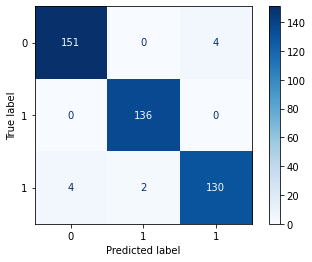

In [144]:
plot_confusion_matrix(clf, X_testc,
                      y_testc, 
                      cmap="Blues",
                      display_labels=y_test)

#### Curva ROC

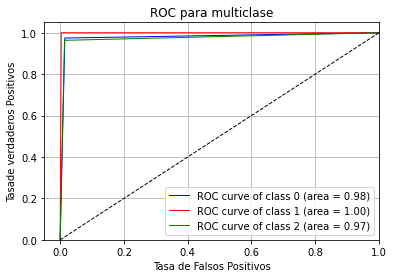

In [137]:
y_testcroc = label_binarize(y_testc, classes=[0, 1, 2])
y_testroc = label_binarize(y_test, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_testcroc[:, i], y_testroc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasade verdaderos Positivos')
plt.title('ROC para multiclase')
plt.legend(loc="lower right")
plt.grid(True)


### Modelo 2 (Red Neuronal)

In [475]:
_input = keras.Input(shape=Xc.shape[1])

caps = Dense(256, activation="relu", kernel_initializer='random_normal')(_input)
caps = Dense(128, activation="tanh")(caps)
caps = Dense(64, activation="sigmoid")(caps)
caps = Dense(32, activation="tanh")(caps)
caps = Dense(16, activation="relu")(caps)
caps = Dropout(.1)(caps)
output = Dense(3, activation="softmax")(caps)

model = keras.Model(inputs=_input, outputs=output)

model.compile(loss = "categorical_crossentropy", 
              optimizer = "Adam", 
#               metrics=[keras.metrics.CategoricalAccuracy()]
              metrics=["accuracy"]
             )


In [476]:
stop=EarlyStopping(patience=5,monitor="loss")

y_trainc_ = to_categorical(y_trainc, 3)
y_testc_ = to_categorical(y_testc, 3)

history = model.fit(X_trainc,
                    y_trainc_,
                    batch_size=256,
                    epochs=200,
                    callbacks=[stop],
                    validation_data=(X_testc, y_testc_),
                    verbose = 2,
                    )

Epoch 1/200
7/7 - 0s - loss: 0.7327 - accuracy: 0.6463 - val_loss: 0.4861 - val_accuracy: 0.8899
Epoch 2/200
7/7 - 0s - loss: 0.4406 - accuracy: 0.9009 - val_loss: 0.3412 - val_accuracy: 0.9274
Epoch 3/200
7/7 - 0s - loss: 0.3095 - accuracy: 0.9296 - val_loss: 0.2739 - val_accuracy: 0.9274
Epoch 4/200
7/7 - 0s - loss: 0.2487 - accuracy: 0.9396 - val_loss: 0.2419 - val_accuracy: 0.9321
Epoch 5/200
7/7 - 0s - loss: 0.2034 - accuracy: 0.9419 - val_loss: 0.2192 - val_accuracy: 0.9321
Epoch 6/200
7/7 - 0s - loss: 0.1679 - accuracy: 0.9507 - val_loss: 0.1993 - val_accuracy: 0.9344
Epoch 7/200
7/7 - 0s - loss: 0.1389 - accuracy: 0.9531 - val_loss: 0.1839 - val_accuracy: 0.9391
Epoch 8/200
7/7 - 0s - loss: 0.1080 - accuracy: 0.9713 - val_loss: 0.1666 - val_accuracy: 0.9461
Epoch 9/200
7/7 - 0s - loss: 0.0752 - accuracy: 0.9848 - val_loss: 0.1523 - val_accuracy: 0.9555
Epoch 10/200
7/7 - 0s - loss: 0.0547 - accuracy: 0.9900 - val_loss: 0.1277 - val_accuracy: 0.9625
Epoch 11/200
7/7 - 0s - loss:

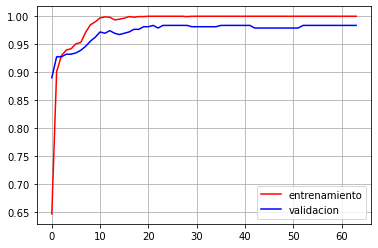

In [477]:
train = history.history["accuracy"]
val = history.history["val_accuracy"]

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Error plots
plt.plot(train, "r", label="entrenamiento")
plt.plot(val, "b", label="validacion")
plt.grid(True)
plt.legend()

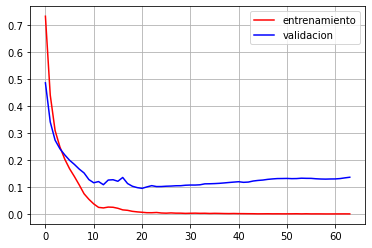

In [478]:
plt.plot(train_loss,"r",label = "entrenamiento")
plt.plot(val_loss, "b", label="validacion")
plt.grid(True)
plt.legend()

In [479]:
model.evaluate(X_testc, y_testc_)

14/14 [==============================] - 0s 3ms/step - loss: 0.1364 - accuracy: 0.9836


[0.13641682267189026, 0.9836065769195557]

In [480]:
y_pred = model.predict(X_testc)

y1 = np.argmax(y_testc_, axis=1)
y2 = np.argmax(y_pred, axis=1)

In [481]:
print("Accuracy:    ", accuracy_score(y1, y2))
print('Recall:    ', recall_score(y1, y2, average="macro"))
print('F1-Score:    ', f1_score(y1, y2, average="macro"))
print('Precision:  ', precision_score(y1, y2, average="macro"))


Accuracy:     0.9836065573770492
Recall:     0.9834440227703984
F1-Score:     0.9833884594839146
Precision:   0.9834921487985454


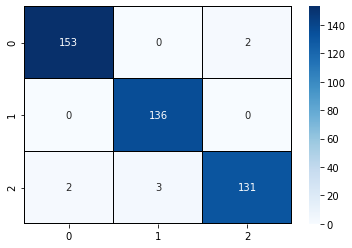

In [482]:
confusion_matrix(y1,y2)
sns.heatmap(confusion_matrix(y1,y2), 
            annot=True,
            cmap=plt.cm.Blues,
            fmt="g",
            linecolor='black',
            linewidths=0.2
           )

## Parte 5 - Despliegue

Despliegue el mejor clasificador de la etapa anterior en un endpoint. El endpoint debe procesar el objeto JSON del *body* de un POST request. El formato del objeto JSON es el siguiente:

```
{"input":[val1,val2,val3, ... ,val2548]}

```
El orden de los valores corresponde al orden de las columnas del archivo `emotions.csv`. La lista tiene 2548 valores que corresponden a los 2548 que su clasificador debe tomar como input. 

El endpoint debe retornar un json de la siguiente forma si la petición fue exitosa: 

```
{"output":"clasfOutput"}
```

Donde "clasfOutput" corresponde a la predicción del clasificador (NEUTRAL, POSITIVE o NEGATIVE).

In [ ]:
# Respuesta a la parte 5 (url del endpoint)


